In [87]:
from astropy.coordinates import AltAz, EarthLocation, get_sun, SkyCoord
from astropy.time import Time
import astropy.units as u
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import numpy as np
from pygdsm import GlobalSkyModel16 as gsm16

In [68]:
# XXX can be more specific, this is hermit's cabin
LON = -113.40314938247553
LAT = 39.247824561729296
FREQ = 75
LMAX = 128

t0 = Time(f"2024-01-01T00:00:00")
ntimes = 120  # times per day
if year % 4 == 0 and not year % 100 == 0 or year % 400 == 0:  # important to be careful about this stuff
    ndays = 366
else:
    ndays = 365
# from 4pm to 8am every night in Mountain Standard Time
local_times = (t0 - 8 * u.hour) + np.arange(ndays)[:, None] * u.day + np.arange(ntimes)[None, :] * 16 * u.hour / ntimes

# convert to utc
times = local_times + 7 * u.hour  # standard mountain time is utc-7
# daylight_start = Time("2024-03-10T02:00:00")  # march 10
# daylight_end = Time("2024-11-03T02:00:00")  # nov 3
# times[(local_times - daylight_start > 0) * (local_times - daylight_end < 0)] -= 1 * u.hour  # dst is utc-6

In [90]:
cyg = SkyCoord("19h59m28.3566s", "40d44m02.096s", frame="fk5")

cyg 8533 299.8681525 40.733915555555555
cas 3607 350.84999999999997 58.815
tau 15291 83.63308333333332 22.0145
virgo 19461 187.70593074999996 12.391123305555555


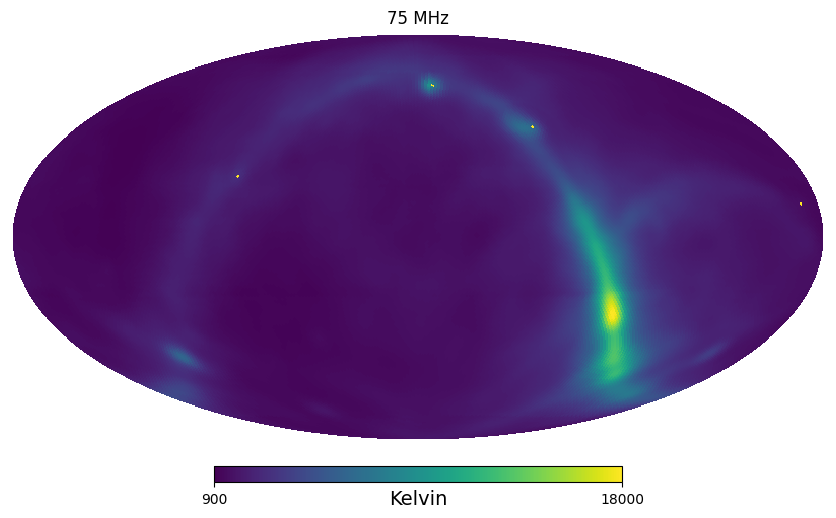

In [109]:
gsm = gsm16(freq_unit="MHz", data_unit="TRJ", resolution="low", include_cmb=True)
m = gsm.generate(FREQ)
NSIDE = hp.get_nside(m)
m = cro.Rotator(coord="GC").rotate_map_alms(m)

# add point sources
sources = {
    "cyg": (SkyCoord("19h59m28.3566s", "40d44m02.096s", frame="fk5"), 10e4),
    "cas": (SkyCoord("23h23m24s", "58d48.9m", frame="fk5"), 10e4),
    "tau": (SkyCoord("05h34m31.94s", "22d00m52.2s", frame="fk5"), 10e4),
    "virgo": (SkyCoord("12h30m49.42338s", "12d23m28.0439s", frame="fk5"), 10e4),
}

for src in sources:
    coord, brightness = sources[src]
    pix = hp.ang2pix(NSIDE, coord.ra.deg, coord.dec.deg, lonlat=True)
    print(src, pix, coord.ra.deg, coord.dec.deg)
    m[pix] += brightness

hp.mollview(m, cbar=True, title=f"{FREQ} MHz", min=900, max=18e3, unit="Kelvin")
sky = cro.Sky.from_healpix(cro.HealpixMap(m, frequencies=FREQ, coord="C"), lmax=LMAX)

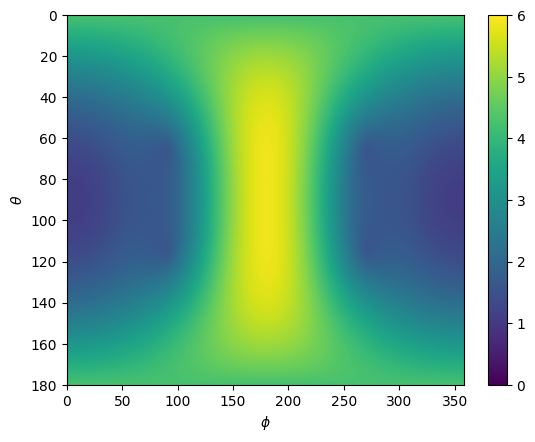

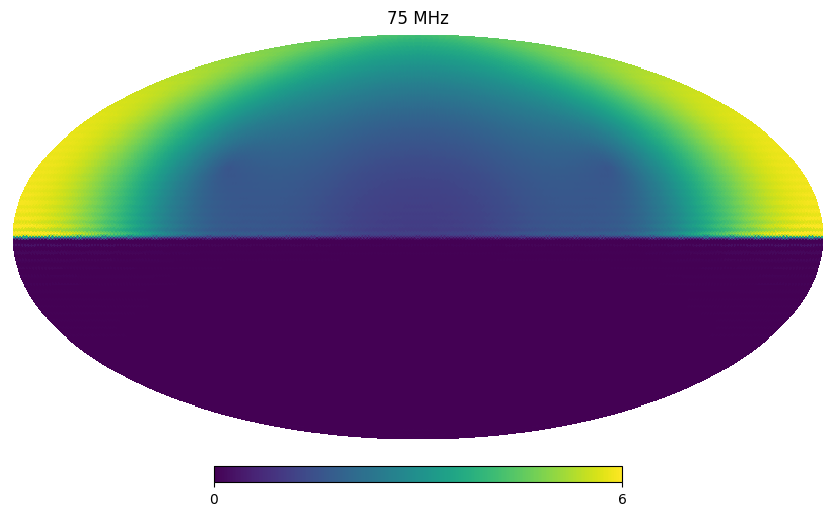

In [105]:
beam = np.loadtxt("vivaldi75mhz.txt", skiprows=2)
theta = np.deg2rad(beam[:, 0]).reshape(360, 181).T
phi = np.deg2rad(beam[:, 1]).reshape(360, 181).T
beam = beam[:, 2].reshape(360, 181).T
# remove phi = 360
theta = theta[:, :-1]
phi = phi[:, :-1]
beam = beam[:, :-1]
plt.figure()
plt.imshow(beam, aspect="auto", extent=[np.rad2deg(angle) for angle in [phi.min(), phi.max(), theta.max(), theta.min()]], vmin=0, vmax=6)
plt.ylabel("$\\theta$")
plt.xlabel("$\\phi$")
plt.colorbar()
plt.show()

beam = cro.Beam.from_grid(beam, theta[:, 0], phi[0], LMAX, frequencies=FREQ, coord="T")
#beam.compute_total_power()
beam.horizon_cut()
hp.mollview(beam.hp_map(NSIDE), cbar=True, title=f"{FREQ} MHz", min=0, max=6)

In [106]:
sim = cro.Simulator(beam, sky, lmax=LMAX, frequencies=None, world="earth", location=(LON, LAT), times=times.ravel())
sim.run(dpss=False)
temp = sim.waterfall.reshape(times.shape)

sunpos = get_sun(times)
sunpos = sunpos.transform_to(AltAz(location=EarthLocation(*(LON, LAT)), obstime=times))

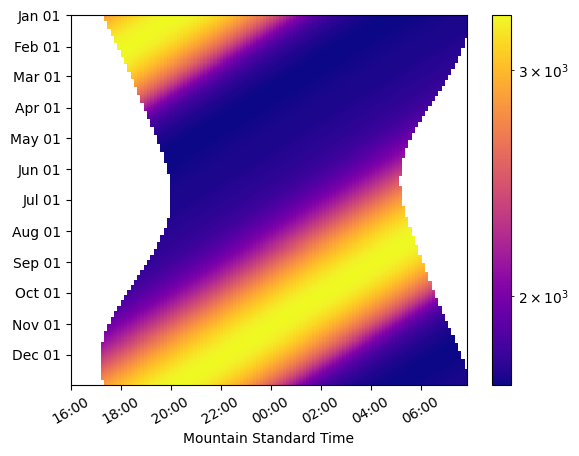

In [107]:
extent = [local_times[0, 0], local_times[0, -1], local_times[-1, 0], local_times[0, 0]]
extent = [t.datetime for t in extent]
colornorm = colors.LogNorm()
plt.figure()
plt.imshow(temp * (sunpos.alt.deg < 0), aspect="auto", interpolation="none", extent=extent, cmap="plasma", norm=colornorm)
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Mountain Standard Time")
plt.xticks(rotation=30)
plt.colorbar()
plt.show()

May 02


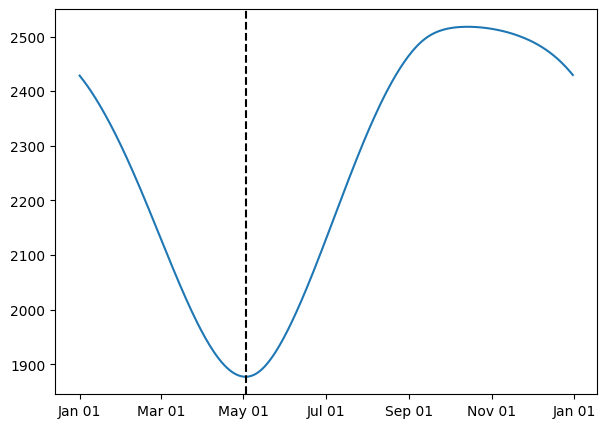

In [108]:
plt.figure(figsize=(7, 5))
plt.plot(times[:, 0].datetime, temp.mean(axis=-1))
best_day = times[np.argmin(temp.mean(axis=1)), 0]
print(best_day.datetime.strftime("%b %d"))
plt.axvline(best_day.datetime, ls="--", c="k")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

## Average sky temperature above horizon (uniform beam)

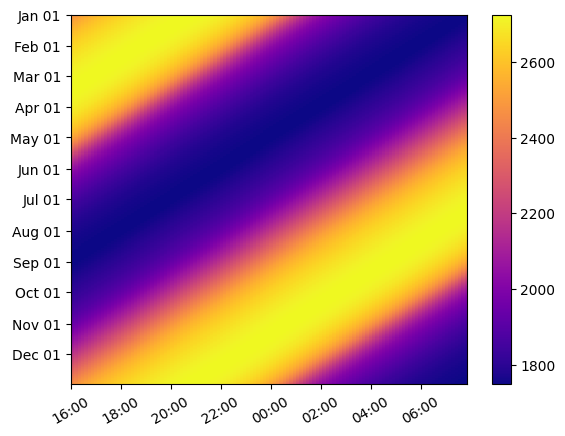

May 04


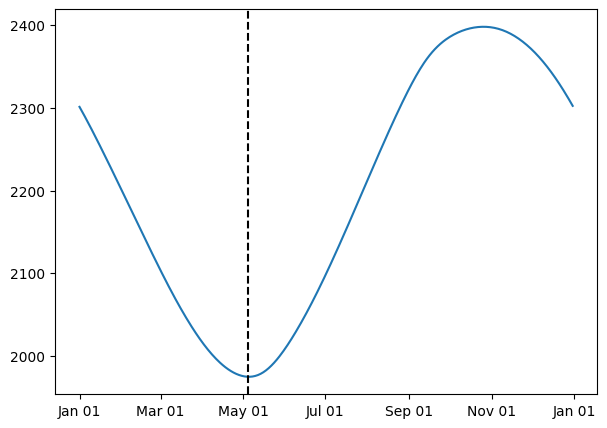

In [103]:
beam = cro.Beam.from_grid(np.ones_like(theta), theta[:, 0], phi[0], LMAX, frequencies=FREQ, coord="T")
beam.horizon_cut()
sim = cro.Simulator(beam, sky, lmax=LMAX, frequencies=None, world="earth", location=(LON, LAT), times=times.ravel())
sim.run(dpss=False)
temp = sim.waterfall.reshape(times.shape)

plt.figure()
plt.imshow(temp, aspect="auto", interpolation="none", extent=extent, cmap="plasma")#, norm=colornorm)
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=30)
plt.colorbar()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(times[:, 0].datetime, temp.mean(axis=-1))
best_day = times[np.argmin(temp.mean(axis=1)), 0]
print(best_day.datetime.strftime("%b %d"))
plt.axvline(best_day.datetime, ls="--", c="k")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()